<a href="https://colab.research.google.com/github/aTrotier/COURS_RECO_BART/blob/main/TP_reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Travaux Pratique

## Manipulation de l'espace de Fourier

1) Générer un phantom de taille 128 dans le domaine de fourier en utilisant la fonction bart `phantom` (regarder les options possible grâce à `!bart phantom -h` et affichez le résultat (`pyplot.imshow`). Pensez à changer le fenêtrage de l'image pour mieux visualiser les données (option : `vmin=0, vmax=0.03`).

2) Appliquer une maintenant une fft inverse sur les données `bart fft`
Affichez l'image du module et l'image de la phase.

3) Que se passe t-il si l'on reconstruit une image avec seulement la zone centrale de l'espace de Fourier (et seulement l'extérieur) ?
Vérifier votre réponse en comparant les images

## Zero-Filling

Le zero-filling est une opération courante consistant à augmenter la taille de l'espace de fourier en ajoutant des zéros autour des données réellement acquise.

4) Quelle est l'effet sur la taille des pixels ? Vérifier votre réponse en affichant l'image avec un zero-filling de 2 : matrix 128x128 -> 256x256

## Sous-échantillonnage
Une méthode courante d'accélération des acquisitions IRMs consiste à ne lire qu'une ligne sur 2 de l'espace de Fourier.

5) Quel est l'effet sur l'image ? Afficher l'image puis ecriver une equation permettant de lier le signal d'un pixel de l'image reconstruite en sautant une ligne sur 2 à l'image provenant de l'espace de Fourier complément échantilloné.

## Antennes d'acquisitions multiples

Dans l'équation du signal d'un voxel que vous venez d'écrire, vous avez une mesure (un pixel de l'image repliée) pour 2 inconnues (2 pixels de l'image **fully**). Pour résoudre ce soucis, l'utilisation d'antennes d'acquisition à plusieurs canaux à été développée.

6) Générer un example d'espace de Fourier avec 8 antennes `kspace_8ch = bart(1,"phantom -k -s 8")`. Quelle est la taille de la matrice ? Ajouter du bruit à cet espace de fourier avec la fonction `kspace_8ch_noise = bart(1,"noise -n 100",kspace_8ch)`

7) Afficher la magnitude de l'image après une FFT de l'antenne 1 et 4 pour visuliser les différences. De même pour la phase.

8) Comment peut-on combiner les données ensemble ? Proposer plusieurs solutions et implémenter le résultat. Augmenter la variance du bruit pour visualiser l'effet sur la combinaison des antennes. 

La méthode la plus utilisé est la méthode Sum of Square : $$im = \sqrt{\sum{abs(im)^2}}$$

## Carte de sensibilité

Pour une combinaison optimale des données, il est nécessaire d'utiliser la carte de sensibilité des antennes de réception. Il existe plusieurs méthodes permettant de les calculer. BART dispose de 3 fonctions :
* caldir
* ecalib
* walsh

9) Implémenter la méthode caldir et ecalib (attention il faut mettre l'option -m1 pour celle-ci) et comparer les cartes de sensibilités générée pour l'antenne 1 et 4.

## Combinaison idéale 
L'image de l'antenne L est égale à : 
$$m_l(x,y) = C_l(x,y)\ m(x,y) + n_l(x,y)$$

Ici on veut retrouver M, connaissant im_L. La matrice n'est pas carré/inversible.
Il faut utiliser -> Moore-penrose pseudo inverse

$$\hat{m}(x,y) = (C^* \  \Psi^{-1} \ C)^{-1} C^* \ \Psi^{-1}\  m_s(x,y)$$

en considérant que le bruit est non corrélé entre les antennes

$$\Psi = \sigma^2 I$$

on obtient : 
$$\hat{m}(x,y) = (C^* \ C)^{-1} C^* \  m_s(x,y) = \frac{1}{\sum_l{|C_l(x,y)|^2}} \sum_l{C_l^*(x,y) \ m_{s,l}(x,y)}$$

11) Comparer la reconstruction SOS avec cette méthode dans le cas d'un faible signal sur bruit.

## Imagerie parallèle

12) Comme dans la question 5) effectuer un sous-échantillonnage des données avec plusieurs antenne. Laisser la possibilité de choisir le facteur de sous-échantillonnage Rx.

 **Résolution du problème**
\begin{equation*}
\begin{bmatrix}
m_1(x,y) \\
m_2(x,y)\\
\vdots \\
m_l(x,y)
\end{bmatrix} = 
\begin{bmatrix}
C_1(x,y) & C_1(x+N_x/2,y) \\
C_2(x,y) & C_2(x+N_x/2,y) \\
\vdots \\
C_L(x,y) & C_L(x+N_x/2,y)
\end{bmatrix}
\begin{bmatrix}
m(x,y) \\
m(x+N_x/2,y) 
\end{bmatrix}
\end{equation*}

12) Implémenter la reconstruction sense dans une fonction retournant l'image dépliée.


Implementation matlab -> https://users.fmrib.ox.ac.uk/~mchiew/docs/SENSE_tutorial.html 
qui a été implémenté en python -> https://github.com/mckib2/pygrappa/blob/025ed5470187d654fa9acc23d84b68c87bbe8f33/pygrappa/sense1d.py#L8

```
function out = SENSE(input,sens,R)
    [Nx,Ny,Nz,Nc] = size(input);
    out = zeros(Nx,Ny);
    % loop over the top-1/R of the image
    for x = 1:Nx/R
        x_idx = x:Nx/R:Nx;
        % loop over the entire left-right extent
        for y = 1:Ny
            % pick out the sub-problem sensitivities
            S = transpose(reshape(sens(x_idx,y,1,:),R,[]));
            % solve the sub-problem in the least-squares sense
            out(x_idx,y) = pinv(S)*reshape(input(x,y,1,:),[],1);
        end
    end
end
```

13) Modifier le bruit sur les images pour visualiser l'effet sur la reconstruction

14) Augmenter le facteur Rx pour visualiser l'effet sur l'image

## Mesure du SNR

<a href="https://colab.research.google.com/github/aTrotier/COURS_RECO_BART/blob/main/cours_bart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



Dans ce cours nous utiliserons [BART](https://mrirecon.github.io/bart/) qui est une librairie de fonction permettant de reconstruire les données IRM

La première étape et d'installer BART dans google colab : https://colab.research.google.com/

# Installation librairie

In [ ]:
!apt-get -qq install -y  gcc make libfftw3-dev liblapacke-dev libpng-dev libopenblas-dev gfortran

# Installation de BART à partir de github

In [ ]:
!git clone https://github.com/mrirecon/bart

Cloning into 'bart'...
remote: Enumerating objects: 12253, done.
remote: Counting objects: 100% (488/488), done.
remote: Compressing objects: 100% (298/298), done.
remote: Total 12253 (delta 275), reused 307 (delta 189), pack-reused 11765
Receiving objects: 100% (12253/12253), 8.23 MiB | 15.30 MiB/s, done.
Resolving deltas: 100% (8886/8886), done.


Checkout vers version 0.7



In [ ]:
cd bart

[Errno 2] No such file or directory: 'bart'
/content/bart


In [ ]:
!git checkout v0.7.00

Note: checking out 'v0.7.00'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at d1b0e57 bump version


**Compilation**

In [ ]:
!PARALLEL=1 make

In [ ]:
!make install

make MAKESTAGE=2 install
make[1]: Entering directory '/content/bart'
install -d //usr/local//bin/
install bart //usr/local//bin/
install -d //usr/local//share/doc/bart/
install /content/bart/doc/*.txt /content/bart/README //usr/local//share/doc/bart/
install -d //usr/local//lib/bart/commands/
make[1]: Leaving directory '/content/bart'
install -d //usr/local//bin/
install bart //usr/local//bin/
install -d //usr/local//share/doc/bart/
install /content/bart/doc/*.txt /content/bart/README //usr/local//share/doc/bart/
install -d //usr/local//lib/bart/commands/


In [ ]:
!bart

BART. Available commands are:
avg         bench       bin         bitmask     cabs        caldir      
calmat      carg        casorati    cc          ccapply     cdf97       
circshift   conj        conv        conway      copy        cpyphs      
creal       crop        delta       ecalib      ecaltwo     estdelay    
estdims     estshift    estvar      extract     fakeksp     fft         
fftmod      fftrot      fftshift    filter      flatten     flip        
fmac        homodyne    index       invert      itsense     join        
looklocker  lrmatrix    mandelbrot  mip         moba        mobafit     
nlinv       noise       normalize   nrmse       nufft       ones        
pattern     phantom     pics        pocsense    poisson     pol2mask    
poly        repmat      reshape     resize      rmfreq      rof         
roistat     rss         rtnlinv     sake        saxpy       scale       
sdot        show        signal      slice       spow        sqpics      
squeeze     ssa      

# Test utilisation BART avec Python

Préparation des fonctions pour être utilisées avec python

In [ ]:
import os
import sys
import numpy as np

os.environ['TOOLBOX_PATH'] = '/content/bart'
path = os.environ["TOOLBOX_PATH"] + "/python/"
sys.path.append(path)

from bart import bart
import cfl

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

Generate a phantom with BART and plot the image

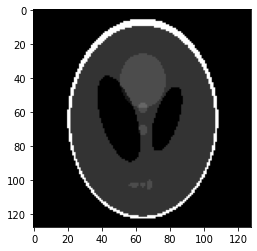

In [ ]:
x = bart(1, 'phantom')
plt.figure()
plt.imshow(abs(x), cmap='gray')

# Utilisation bart

BART s'utilise en ligne de commande mais peut être utilisé gâce à un wrapper python (ce que l'on fera dans la suite de ce cours)

In [ ]:
!bart phantom -h

Usage: phantom [-s d] [-S d] [-k] [-t <string>] [-G ...] [-T ...] [-N d] [-B ...] [-x d] [-g d] [-3] [-b] [-r d] <output>

Image and k-space domain phantoms.

-s nc      	nc sensitivities
-S nc      	Output nc sensitivities
-k		k-space
-t file      	trajectory
-G		geometric object phantom
-T		tubes phantom
-N num      	Random tubes phantom and number
-B		BART logo
-x n      	dimensions in y and z
-g n=1,2      	select geometry for object phantom
-3		3D
-b		basis functions for geometry
-r seed      	random seed initialization
-h		help


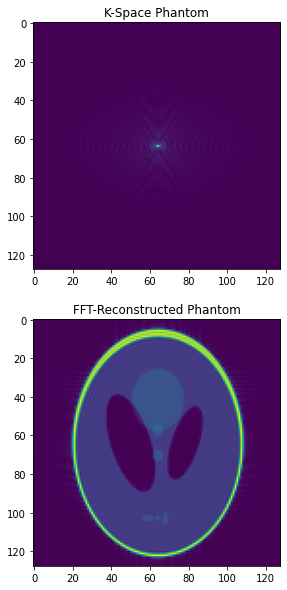

In [ ]:
# Generating a k-space phantom and applying an inverse FFT.
shepp_kspace = bart(1, "phantom -k -x 128")
shepp_fft = bart(1, "fft -i 3", shepp_kspace)

fig, ax = plt.subplots(nrows=2, figsize=(6, 10))
ax[0].set_title("K-Space Phantom")
ax[0].imshow(abs(shepp_kspace))

ax[1].set_title("FFT-Reconstructed Phantom")
ax[1].imshow(abs(shepp_fft))